# Fashion-MNIST - Machine Learning Task
This notebook contains description of solution for **Fashion-MNIST** machine learning task. Presentation is divided into 7 parts.
1. **Data preparation**
> This introductory part describes data preprocessing and data splitting operations.
2. **Data augmentation**
> All implemented data augmentations techniques are shown here.<br/>There are also some interactive examples.
3. **Modeling**
> In modeling part, used architectures and training setups are presented.<br/>Loss functions, optimizers and other training related details can be found here.
4. **Experimental setup**
> In this section varoius aspects of performed experiments are considered.
5. **Results**
> Results of experiments and important measurements are shown here.<br/>Also, there are some visualizations of training processes and corresponding discussions.
6. **Error analysis and further improvements**
> Error analysis section presents model errors in a compact form, which provides an useful insight into to how errors are distributed, and what are possible directions for further improvements.
7. **Demo**
> Classification of random images from the test set.

In [1]:
import numpy as np

from plot_utils import *
from data_utils import load_fashion_mnist, Augmenter

## 1. Data preparation

Fashion-MNIST dataset is loaded using `fashion_mnist` module from `tensorflow.keras.datasets`.
<br/>
Image pixel values are normalized to range from 0 to 1 and labels are transformed into one-hot vectors.
<br/><br/>
Training data of **60000** examples is divided into two datasets:
* Training set of **50000** examples - `X_train` and `y_train`
* Validation set of **10000** examples - `X_val` and `y_val`


Test data `X_test` and `y_test` contains **10000** examples.

In [3]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_fashion_mnist()

Visualize some samples

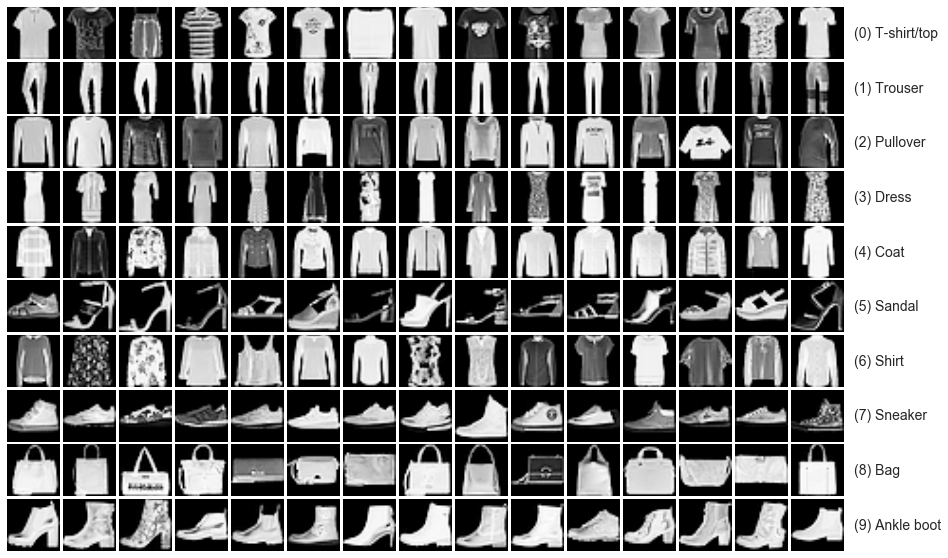

In [3]:
visualize_samples(X_train, y_train)

**NOTES:** All images are black and white with shape `(28, 28, 1)`. Images from all but footwear classes are almost horizontally symmetric. In each image object of interest is mostly centered and not rotated. Thus, basic data augmentation strategies like flipping, translations and rotations are not enough. This means that more advanced augmentation strategies should be performed.

## 2. Data augmentation
In order to prevent overfitting and enhance model generalization capabilities, 3 types of augmentations are implemented:
* **Basic augmentations**
    * Random horizontal flipping (excluding footwear classes)
    * Random translations along `x` and `y` axis by `dx` and `dy` pixels
* **Mixup augmentation**
    * Mixing images and corresponding labels, described here: https://arxiv.org/pdf/1710.09412.pdf
* **Random erasing augmentation**
    * Filling random rectangular area of an image with a noise, described here: https://arxiv.org/pdf/1708.04896.pdf

Data augmentation is implemented as `Augmenter` class. Class has method `flow` that returns generator of batches. 
<br/><br/>
Class `ImageDataGenerator` from `tensorflow.keras.preprocessing.image` was inefficient and not flexible enough, so the custom augmenter class is implemented. To speed up data generation process, most of operations are implemeted as "in-place" operations.

**Mixup** augmentation examples

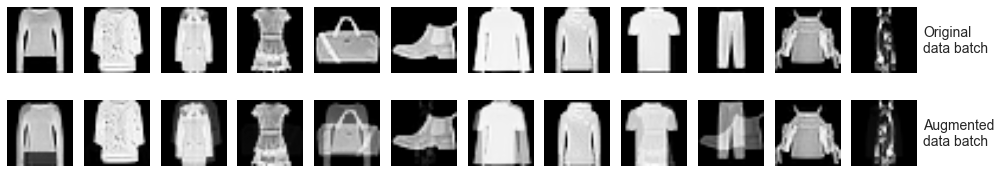

In [6]:
# 'alpha' is parameter of beta distribution from which mixing weights are drawn
# larger 'alpha' leads to more mixing, you can change alpha to see the effects of augmentation

augmenter = Augmenter(x_flip=True, dx=1, dy=1, mixup=True, alpha=0.4)

sample = np.random.randint(len(X_train), size=12)
X_sample, y_sample = X_train[sample], y_train[sample]

visualize_augmentations(augmenter, X_sample, y_sample)

**Random erasing** augmentation examples

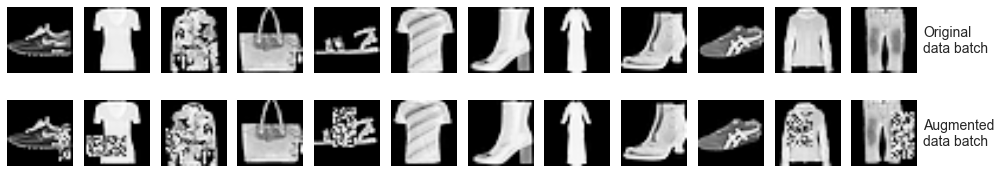

In [7]:
# paramater 'p' in random erasing augmentation controls the probability of random erasing
# larger values of 'p' leads to more frequent erasing augmentations

augmenter = Augmenter(x_flip=True, dx=1, dy=1, re=True, p=0.5)

sample = np.random.randint(len(X_train), size=12)
X_sample, y_sample = X_train[sample], y_train[sample]

visualize_augmentations(augmenter, X_sample, y_sample)

## 3. Modeling

### 3.1 Implemented architectures
***
**SimpleNet-V1**
***
`SimpleNetV1` is the frist simple architecture. Every `Conv2D` layer has 128 filters with 3x3 kernels, 1x1 stride, "valid" padding and `ReLU` activation. Pooling layers performs 2x2 max pooling operation. `Flatten` layer prepares activations for hidden `Dense` layer with 128 units. Number of units in the last `Dense` layer is equal to the number of classes.
<br/><br/>
Number of parameters: **707,594**
<img src="images/simple_net_v1.png"/>
***
**SimpleNet-V2**
***
`SimpleNetV2` is the second simple architecture. It contains six blocks of `(Conv2D, BachNorm, ReLU)` triplets. Every `Conv2D` layer has 3x3 kernel and "same" padding. Even convolutional layers have stride of 2x2, while odd layers have stride of 1x1. Number of filters are increasing from input to ouput: (32, 32, 64, 64, 128, 256). `GlobalAveragePooling2D` is applied before final `Dense` classification layer with 10 units.
<br/><br/>
Number of parameters: **438,890**
<img src="images/simple_net_v2.png"/>
***
**ResNet-18 PreAct** - Full and Light version
***
`ResNet18_Full` and `ResNet18_Light` are implementations of standard resnet-18 specification. First network with `Full` siffix is the standard resnet-18 architecture. In `Light` version number of filters in all `Conv2D` layers are reduced by half.
<img src="images/res_net_18.png"/>
Number of parameters (`Full` version): **11,176,778**
<br/>
Number of parameters (`Light` version): **2,799,018**

### 3.2 Training setup

For all models `Adam` optimizer with default parameters is used. Loss function is `categorical_cross_entropy`.
<br/><br/>
Batch size for all models is **128**.
<br/><br/>
`SimpleNetV1` and `SimpleNetV2` are trained for **100** epochs.
<br/>
`ResNet18_Light` and `ResNet18_Full` are trained for **150** epochs.
<br/><br/>
Following learning rate schedulers are used:
* `lr_scheduler_1` for `SimpleNetV1` and `SimpleNetV2`
* `lr_scheduler_2` for `ResNet18_Light` and `ResNet18_Full`

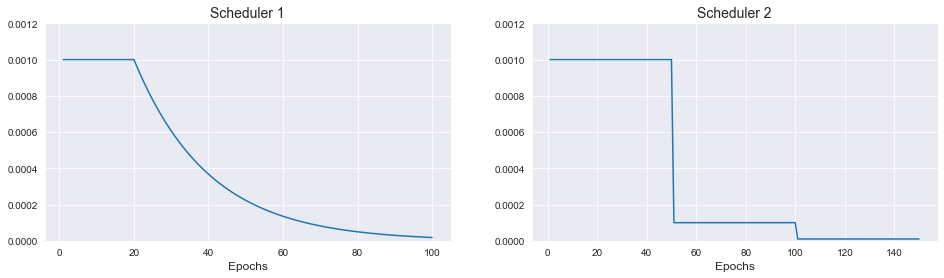

In [5]:
from train_utils import lr_scheduler_1, lr_scheduler_2
visualize_schedulers(lr_scheduler_1, 100, lr_scheduler_2, 150)

## 4. Experimental setup

Experimental setup includes all possible combinations of models and types of augmentations.
<br/><br/>
There are **4** types of model architectures:
* `SimpleNetV1`
* `SimpleNetV2`
* `ResNet18_Light`
* `ResNet18_Full` 
<br/>

And **3** types of augmentations (each type includes basic geometric augmentations):
* Mixup
* Random Erasing
* Mixup + Random Erasing

There are **12** possible experiments. For each experiment following metrics are computed:
* **Training speed** - average training time per epoch
* **Inference speed** - average inference time per image from test set
* **Model accuracy / error** - model accuracy / error on test set
* **Training curves** - loss and error curves both for training and validation set

Models are trained on **nVidia GeForce GTX 1080Ti** graphic card.
<br/><br/>
Experiments are launched with `run_experiments.py` script file.
<br/><br/>
Model weights are saved in `WEIGHTS_DIR` directory in `h5` format.
<br/>
Results of experiments are saved in `RESULTS_DIR` directory in `json` format.

## 5. Results

Final results are presented in the table below. _Inference_ column shows model inference speed in microseconds as an avarege time for classifying one image. Training speeds are expressed in _Training_ column as an average time in seconds for one training epoch. Other columns are self-explanatory, and bolded accuracy values are the best accuracies for each particular architecture.

| Model | Parameters | Inference [ $\mu$s / image] | Augmentation | Training [ s / epoch] | Accuracy [ % ] |
| :--- | :--- | :--- | :--- | ---: | ---: |
| SimpleNet-V1 | 707,594 | 45 | mixup | 7.5 | 94.49 |
|  |  |  | random erasing | 9.3 | **94.61** |
|  |  |  | mixup + random erasing | 9.6 | 94.52 |
| --- |  |  |  |  |  |
| SimpleNet-V2 | 438,890 | 38 | mixup | 6.1 | 94.67 |
|  |  |  | random erasing | 8.2 | 94.57 |
|  |  |  | mixup + random erasing | 8.5 | **94.72** |
| --- |  |  |  |  |  |
| ResNet-18 Light | 2,799,018 | 91 | mixup | 12.8 | **95.52** |
|  |  |  | random erasing | 14.7 | 94.97 |
|  |  |  | mixup + random erasing | 15.0 | 95.43 |
| --- |  |  |  |  |  |
| ResNet-18 Full | 11,176,778 | 147 | mixup | 24.6 | **95.57** |
|  |  |  | random erasing | 26.5 | 95.19 |
|  |  |  | mixup + random erasing | 26.8 | 95.40 |

**NOTES:** Besides obvious dependency between model size (parameters) and training and inference speed, experiments showed that augmentation slows down training process to some extent. However, general impression is that both random erasing and mixup augmentation improve the model performance, and sometimes combinations of these two can give the best results.<br/><br/>Another important note is that small models, like `SimpleNetV2`, which is an order of magnitude smaller than the best performing models, can still give competitive and acceptable performance in terms of accuracy, inference and training speed.

### 5.1 Learning curves for `SimpleNetV1` and `SimpleNetV2`

Learning curves clearly shows the benefits of using implemented augmentations in preventing model overfitting. However, as we can see from these curves, random erasing still does not eliminate overfitting problem completely (third colum on plots below), and maybe some model regularization strategies should be introduced.
<br/><br/>
As stated earlier, learning rate for these two models are governed by `lr_scheduler_1`. Although `Adam` optimizer uses advanced approach for learning rate adaptation, it turned out that scheduling initial learning rate, that `Adam` uses internally, really helps reaching better validation scores in this particular case.

**Learning ERROR**

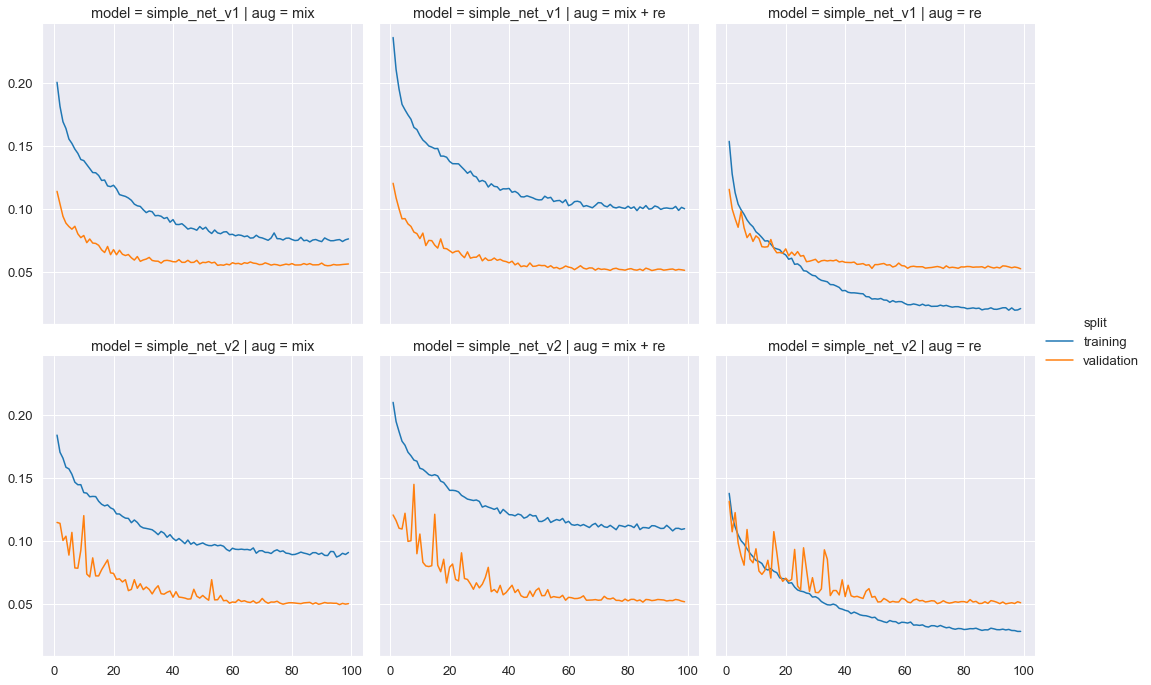

In [2]:
plot_learning_curves(model_type="simple_net", metric="error", skip_epochs=1)

**Learning LOSS**

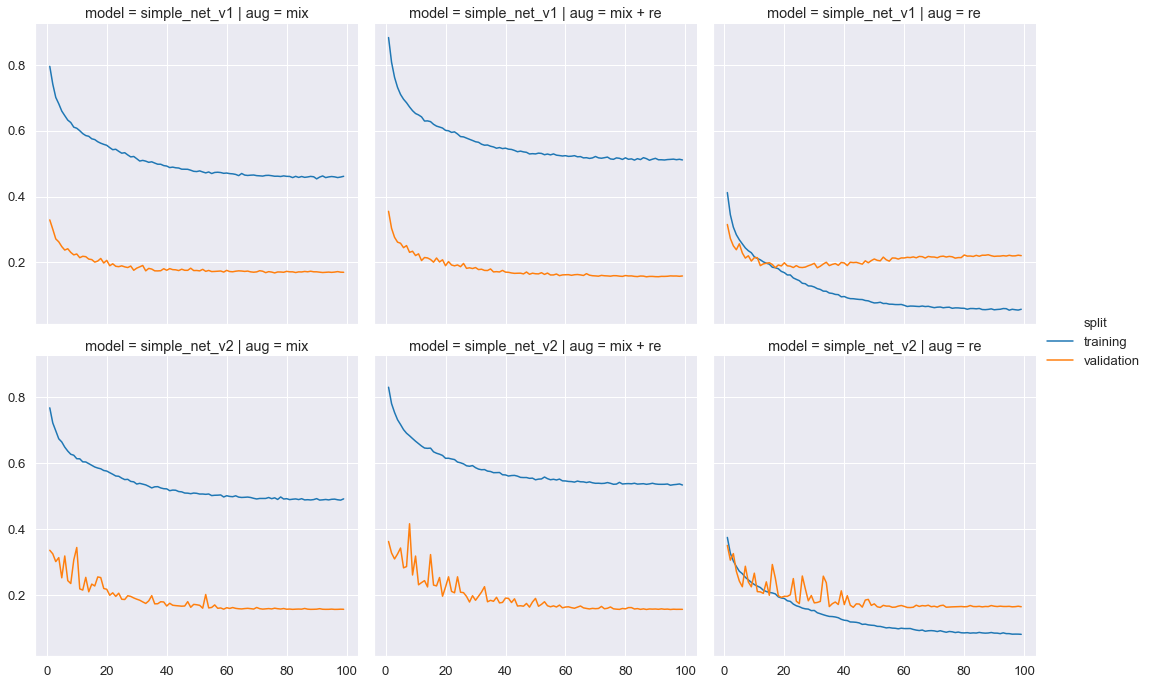

In [19]:
plot_learning_curves(model_type="simple_net", metric="loss", skip_epochs=1)

### 5.2 Learning curves for `ResNet18_Light` and `ResNet18_Full`

Everything mentioned above still holds in case of larger models. With random erasing models still overfit. Here we can see that larger models reduces the gap between trainig and validation curves more than simpler models. Also more complex models are less biased and traning curves reach lower values.
<br/><br/>
Here we can also see that `lr_scheduler_2` helps `Adam` to achieve better scores, which is clear from the plots (drop in training and validation error after 50th epoch). However, learning curves saturate later, and maybe more careful learning rate scheduling should be employed, or models are simply not complex enough to achieve even lower training errors / losses.

**Learning ERROR**

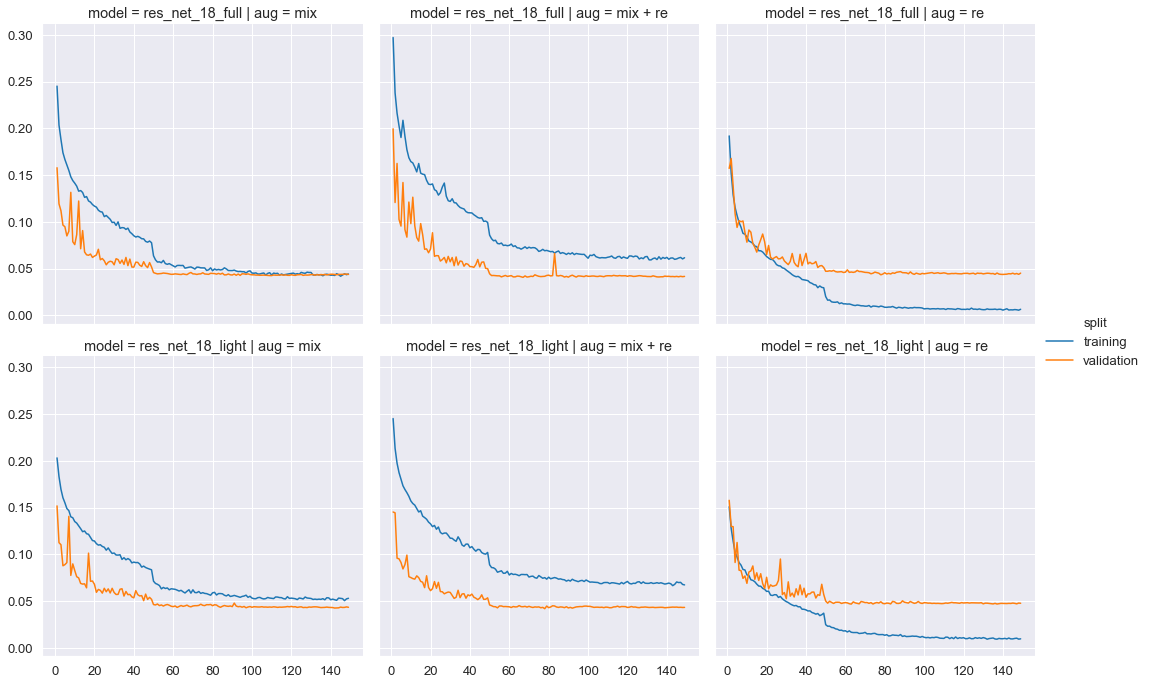

In [3]:
plot_learning_curves(model_type="res_net", metric="error", skip_epochs=1)

**Learning LOSS**

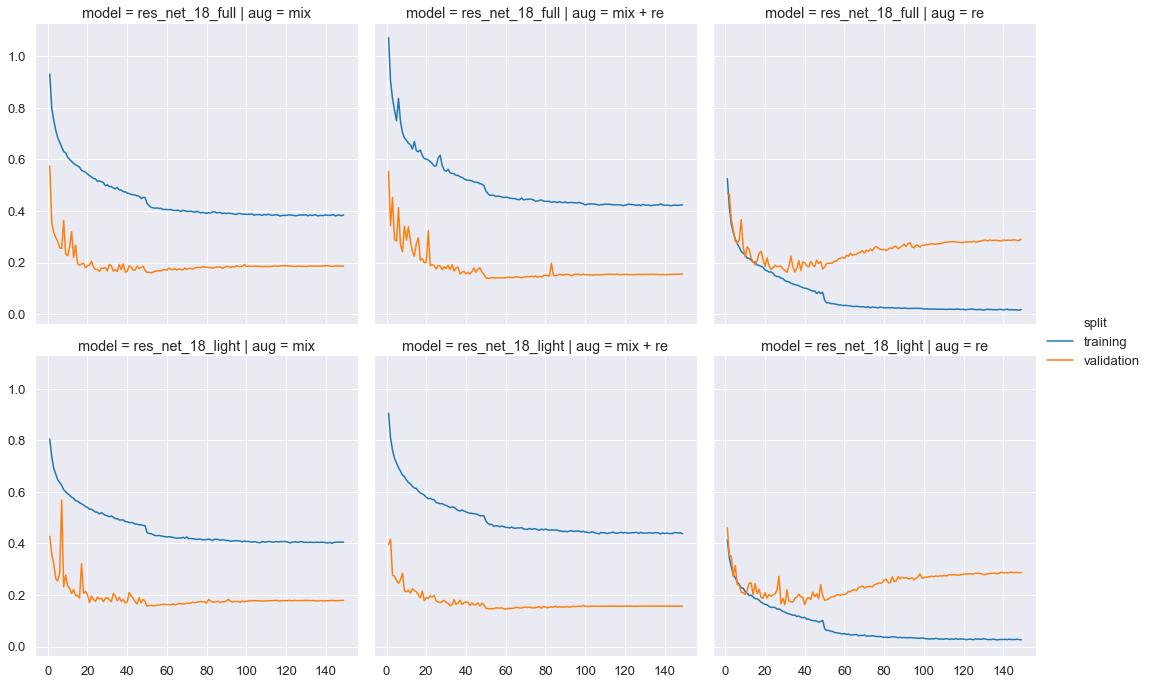

In [4]:
plot_learning_curves(model_type="res_net", metric="loss", skip_epochs=1)

## 6. Error analysis and further improvements

Load the best performing model - `ResNet18_Full` model trained with mixup augmentation

In [5]:
from models import ResNet18_Full

model = ResNet18_Full(
    input_shape=(28, 28, 1), num_classes=10,
    weights_file="weights/res_net_18_full_mix.h5")

Confusion matrix and per-class precision/recall metrics

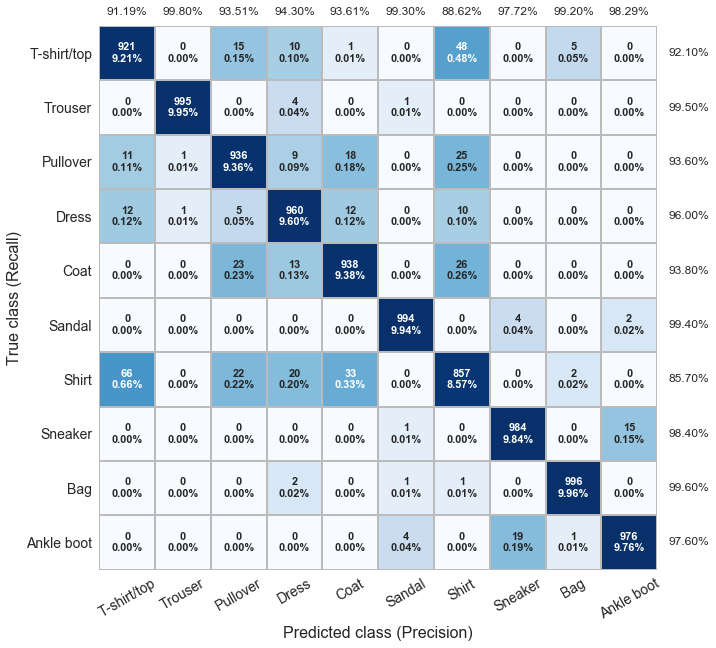

In [4]:
y_true = y_test.argmax(axis=1)
y_pred = model.predict(X_test).argmax(axis=1)

plot_confusion_matrix(y_true, y_pred)

**NOTES:** Confusion matrix above provides an useful insight of error distribution. It is clearly obvious that errors are concetrated around particular groups of classes. Classes like **Trouser**, **Sandal** or **Bag** are easy ones, and model is pretty confident with them. On the other side, class pairs like **T-shir/top** and **Shirt**  or **Sneaker** and **Ankle boot**, are very similar visually and thus more confusing.
<br/><br/>
All that lead to conclusion that some specialized loss function, with appropriate penalization strategy, can address this problem of frequently confusing classes and make the model even better.

## 7. Demo

Execution of cell bellow demonstrates classification of random images from `X_test`.
<br/>
Image along with true class is shown on the left side, and the model outputs (softmax activations) are shown on the right side.

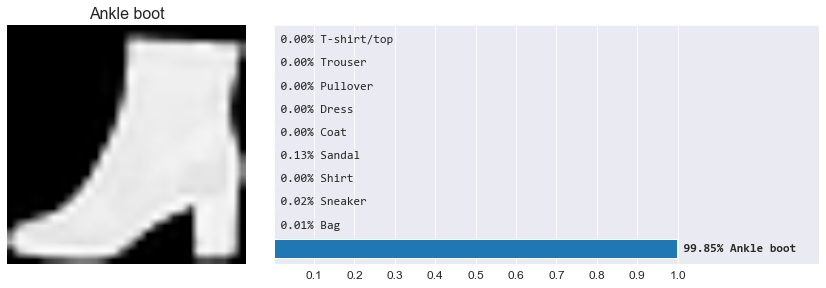

In [8]:
show_demo(X_test, y_test, model)